## Define ChatModel


In [16]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
import streamlit as s
from IPython.display import display, Markdown

In [11]:
load_dotenv(dotenv_path="../.env")
llm = ChatGroq(
  model="qwen/qwen3-32b",
  temperature=.2,
  max_tokens=None,
   reasoning_format="parsed",
)

In [17]:
# test chat model
response = llm.invoke(input="Give me one information about Messi")
display(Markdown(response.content))

Lionel Messi, widely regarded as one of the greatest footballers of all time, led Argentina to victory in the **2022 FIFA World Cup** in Qatar, defeating France in a historic final. This triumph marked the pinnacle of his career, ending his long quest for a World Cup title and cementing his legacy as a global icon.

## Single Agent


In [18]:
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Any

In [2]:
SINGLE_AGENT_SYSTEM = """
  You are helpful AI.
  Task: Provide a well-reasoned recommendation to the user question.
  Rules:
  - Take your best effort without browsing the web.
  - Be structured: Summary, Pros, Cons, Recommendation, Risks, Confidence(0-100).
"""

In [19]:
def single_agent_answer(question:str) -> str | Any:
  msgs = [
    SystemMessage(content=SINGLE_AGENT_SYSTEM),
    HumanMessage(content=question)
  ]
  
  return llm.invoke(msgs).content

In [20]:
# test single agent

question = "Should a startup use open-source LLMs or closed models in 2026? Consider cost, speed, privacy, and reliability"

response = single_agent_answer(question=question)

display(Markdown(response))

**Summary**  
By 2026, startups should prioritize **open-source LLMs** for cost efficiency, customization, and data control, but **closed models** may be preferable for speed, reliability, and ease of integration. The choice depends on the startup’s specific needs, technical capabilities, and risk tolerance.

---

**Pros and Cons**  

| **Factor**       | **Open-Source LLMs**                                                                 | **Closed Models**                                                                 |
|-------------------|--------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------|
| **Cost**          | Low licensing costs; potential infrastructure expenses for hosting/training.         | Predictable pay-per-use or subscription fees; higher costs at scale.              |
| **Speed**         | May require optimization for performance; cloud-hosted options can match closed models. | Optimized for speed via cloud infrastructure; faster deployment.                |
| **Privacy**       | Full data control; no third-party data sharing.                                      | Risk of data exposure to third-party providers; compliance certifications may help. |
| **Reliability**   | Community-driven updates; potential instability if the project is under-maintained.  | High reliability with enterprise-grade support and SLAs.                          |
| **Customization** | Full access to code for fine-tuning and domain-specific training.                    | Limited to API-level customization; less flexibility for unique use cases.        |

---

**Recommendation**  
- **Choose open-source LLMs** if:  
  - The startup requires **customization** (e.g., domain-specific training).  
  - **Data privacy** is critical (e.g., healthcare, finance).  
  - The team has technical expertise to manage infrastructure and fine-tuning.  
  - Long-term cost savings are a priority.  

- **Choose closed models** if:  
  - **Speed** and **ease of deployment** are critical (e.g., time-to-market constraints).  
  - The startup lacks in-house ML expertise to manage open-source models.  
  - **Reliability** and enterprise support are non-negotiable (e.g., mission-critical applications).  

---

**Risks**  
- **Open-source**: Risk of obsolescence if the model is not actively maintained. Infrastructure costs may outweigh savings if not optimized.  
- **Closed models**: Vendor lock-in, potential cost spikes, and limited control over model behavior or data.  

---

**Confidence**  
**75/100**. While open-source LLMs are likely to dominate for cost and privacy by 2026, closed models will retain advantages in reliability and ease of use. The decision hinges on the startup’s technical maturity and use case.

## Multi Agents


- Planner: Breaks the user’s question into a clear plan, key risks, and the structure of the final answer.
- Researcher: Gathers and organizes relevant information needed to execute the plan.
- Writer: Produces or revises the draft answer based on the plan, research, and feedback.
- Critic: Evaluates the draft for quality, gaps, and risks, and assigns a score with concrete improvement suggestions.
- finalizer: Produces the final, polished answer once the quality threshold is met.


#### Define Structured outputs


In [25]:
from pydantic import BaseModel, Field
from typing import List, Optional

In [26]:
class Plan(BaseModel):
  steps:List[str] = Field(..., description="Short ordered steps for solving the tasks.")
  key_risks: List[str] = Field(..., description="Major risks/unknowns that should be addressed.")
  desired_output_structure: List[str] = Field(..., description="Headings to include in final answer.")

In [27]:
class Critique(BaseModel):
  issues: List[str] = Field(...,description="Concrete problems with the current draft.")
  missing_points: List[str] = Field(..., description="Important missing considerations.")
  hallucination_risk:List[str] = Field(..., description="Claims that might be risky without sources.")
  score:int = Field(...,ge=0, le=100, description="Overall quality score of the draft.")
  fix_instructions: List[str] = Field(...,description="Actionable steps to improve the draft.")

#### Define LangGraph State


In [29]:
from typing_extensions import TypedDict
from typing import Dict

In [30]:
class GraphState(TypedDict):
  question:str
  plan:Optional[Dict[str, Any]]
  research_notes:List[str]
  draft:Optional[str]
  critique:Optional[Dict[str, Any]]
  iteration:int
  max_iterations: int

#### Agents Nodes [`Planner`, `Researcher`, `Writer`, `Critic`, `Finalizer`]


In [31]:
PLANNER_SYSTEM = """
  You are the planner agent.
  Create a concise plan with steps, key risks, and final output headings.
  Return valid JSON matching the schema.
"""

RESEARCH_SYSTEM = """ 
  You are the Researcher agent.
  you do NOT browse the web. You reason from general knowledge.
  Produce bullet research notes covering: cost, speed, privacy, reliability, compliance, vendor lock-in, iteration speed, support.
  Keep it practical for startups.
"""

WRITER_SYSTEM = """ 
  You are the Writer agent.
  Write a structured answer using the plan headings.
  Use the research notes.
  Be specific, actionable, and include a clear recommendation plus risks.
"""

CRITIC_SYSTEM = """
  You are the Critic agent.
  Review the draft for:
  - missing points
  - weak reasoning
  - overconfidence
  - risky claims
  Return JSON matching the schema.
"""

FINALIZER_SYSTEM = """ 
  You are the finalizer agent.
  Given the Plan + research notes + (optional) critique, produce the
  FINAL answer.
  If critique exists, incorporate fixes.
  Output must be polished and concise with headings and a confidence score.
"""

In [32]:
def planner_node(state:GraphState) -> GraphState:
  structured_planned = llm.with_structured_output(Plan)
  plan_obj = structured_planned.invoke([
    SystemMessage(content=PLANNER_SYSTEM),
    HumanMessage(content=state['question'])
  ])
  state['plan'] = plan_obj.model_dump() # type: ignore
  return state

def research_node(state: GraphState) -> GraphState:
  research_response = llm.invoke([
    SystemMessage(RESEARCH_SYSTEM),
    HumanMessage(content=f"Question:\n{state['question']}\n\nPlan:\n{state['plan']}")
  ]).content
  
  # store as notes (simple split)
  notes = [line.strip("- ").strip() for line in research_response.split("\n") if line.strip()]
  state['research_notes'] = notes
  return state

def writer_node(state: GraphState) -> GraphState:
  resp = llm.invoke([
    SystemMessage(WRITER_SYSTEM),
    HumanMessage(content=f"""
                 Question:
                 {state['question']}
                 
                 Plan:
                 {state['plan']}
                 
                 Research notes:
                 {state['research_notes']}
                 
                 If critique exists, you may improve the accordingly.
                 Critique:
                 {state.get('critique')}
                 """)
  ])
  state['draft'] = resp
  return state

def critic_node(state: GraphState) -> GraphState:
  structured_critic = llm.with_structured_output(Critique)
  critique_obj = structured_critic.invoke([
    SystemMessage(content=CRITIC_SYSTEM),
    HumanMessage(content=f"""
                 Question:
                 {state['question']}
                 
                 Draft:
                 {state['draft']}
                 """)
  ])
  state['critique'] = critique_obj.model_dump()
  state['iteration'] += 1
  return state


def finalizer_node(state: GraphState) -> GraphState:
  resp = llm.invoke([
    SystemMessage(content=FINALIZER_SYSTEM),
    HumanMessage(content=f"""
                 Question:
                {state['question']}

                Plan:
                {state['plan']}

                Research notes:
                {state['research_notes']}

                Critique (if any):
                {state.get('critique')}

                Current draft (if any):
                {state.get('draft')}
                 """)
  ]).content
  
  state['draft'] = resp
  return state

#### Build Graph


In [33]:
from langgraph.graph import StateGraph, END
from typing import Literal
def should_revise(state:GraphState) -> Literal['revise','finalize']:
  if state['iteration'] >= state['max_iterations']:
    return 'finalize'
  score = state['critique']['score']
  if score < 80:
    return 'revise'
  return 'finalize'

In [34]:
workflow = StateGraph(GraphState)

workflow.add_node("planner", planner_node)
workflow.add_node("researcher", research_node)
workflow.add_node("writer",writer_node)
workflow.add_node("critic", critic_node)
workflow.add_node("finalizer",finalizer_node)

workflow.set_entry_point("planner")

workflow.add_edge("planner", "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer","critic")

workflow.add_conditional_edges("critic", 
  should_revise,{
    "revise":"writer",
    "finalize":"finalizer"
  })

workflow.add_edge("finalizer",END)

app = workflow.compile()

#### Graph Visualization


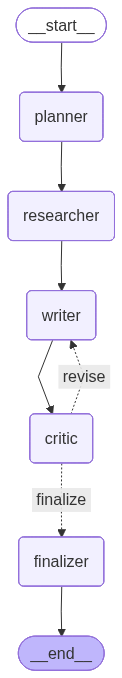

In [35]:
from IPython.display import Image, display

try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as ex:
  print("graph visualization skipped",ex)

#### Running Multi-Agent Graph


In [ ]:
initial_state: GraphState = {
    "question": question,
    "plan": None,
    "research_notes": [],
    "draft": None,
    "critique": None,
    "iteration": 0,
    "max_iterations": 2,
}
result = app.invoke(initial_state)

In [37]:
result

{'question': 'Should a startup use open-source LLMs or closed models in 2026? Consider cost, speed, privacy, and reliability',
 'plan': {'steps': ['Research current trends in open-source and closed LLMs for 2026',
   'Analyze cost structures (licensing, infrastructure, maintenance)',
   'Compare inference/speed performance across deployment scenarios',
   'Evaluate data privacy frameworks and compliance capabilities',
   'Assess reliability through SLAs, community support, and update frequency'],
  'key_risks': ['Rapid technological obsolescence of chosen models',
   'Unanticipated regulatory changes affecting AI deployment',
   'Vendor lock-in risks with closed models',
   'Resource gaps in maintaining open-source solutions'],
  'desired_output_structure': ['Cost Analysis',
   'Speed Comparison',
   'Privacy Implications',
   'Reliability Assessment',
   'Recommendation Matrix']},
 'research_notes': ['**Research Notes: Open-Source vs. Closed LLMs for Startups in 2026**',
  '',
  '### 